# Data Analysis (coupler_NCap_cap_matrix)

## Configuration

Disable cell scrolling.

Parameters are stored in a shared script.

In [1]:
from parameters import *
os.makedirs('scalers', exist_ok=True)
os.makedirs(f'{DATA_DIR}', exist_ok=True)
os.makedirs(f'{DATA_DIR}/npy', exist_ok=True)

## Library

In [2]:
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from sklearn.preprocessing import MinMaxScaler
import joblib

## Datasets

### Load
From https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/tree/main

In [3]:
import pandas as pd

df = pd.read_json("coupler-NCap-cap_matrix.json")

### Look at the data and structure

In [4]:
#look at the first value
first_entry = df.iloc[100]

# Print the headers and their corresponding values
for header, value in first_entry.items():
    print(f"{header}: {value}")

sim_options: {'setup': {'name': 'lom_setup', 'reuse_selected_design': False, 'reuse_setup': False, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 15, 'min_passes': 2, 'min_converged_passes': 2, 'percent_error': 0.1, 'percent_refinement': 30, 'auto_increase_solution_order': 'False', 'solution_order': 'Medium', 'solver_type': 'Iterative', 'run': {'name': 'LOMv2.01', 'components': ['cplr'], 'open_terminations': [['cplr', 'second_end'], ['cplr', 'prime_start'], ['cplr', 'prime_end']], 'box_plus_buffer': True}}, 'simulator': 'Ansys HFSS'}
sim_results: {'top_to_top': 38.61105, 'top_to_bottom': 12.01876, 'top_to_ground': 26.22814, 'bottom_to_bottom': 54.87869, 'bottom_to_ground': 42.33799, 'ground_to_ground': 103.60583, 'units': 'fF'}
design: {'design_options': {'prime_width': '11.7um', 'prime_gap': '5.1um', 'second_width': '11.7um', 'second_gap': '5.1um', 'cap_gap': '4.1um', 'cap_width': '12.9um', 'cap_gap_ground': '5.1um', 'finger_length': '25.9um', 'finger_count': '5

In [5]:
#Look at the headers relevant for us, to start lets only look at the sim_results (our x data) and design (our y data)
sim_results_column = df['sim_results']
print(sim_results_column, '\n\n')

design_column = df['design']
print(design_column)

0      {'top_to_top': 15.654910000000001, 'top_to_bot...
1      {'top_to_top': 65.85844, 'top_to_bottom': 36.2...
2      {'top_to_top': 18.77838, 'top_to_bottom': 2.88...
3      {'top_to_top': 42.46632, 'top_to_bottom': 21.0...
4      {'top_to_top': 43.49158, 'top_to_bottom': 18.4...
                             ...                        
425    {'top_to_top': 20.16504, 'top_to_bottom': 1.02...
426    {'top_to_top': 21.23155, 'top_to_bottom': 3.57...
427    {'top_to_top': 45.47336, 'top_to_bottom': 16.3...
428    {'top_to_top': 18.15142, 'top_to_bottom': 3.52...
429    {'top_to_top': 40.05013, 'top_to_bottom': 15.8...
Name: sim_results, Length: 430, dtype: object 


0      {'design_options': {'prime_width': '11.7um', '...
1      {'design_options': {'prime_width': '11.7um', '...
2      {'design_options': {'prime_width': '11.7um', '...
3      {'design_options': {'prime_width': '11.7um', '...
4      {'design_options': {'prime_width': '11.7um', '...
                             ...       

In [6]:
#take a look at everything in the design dataset
# Flatten the design column
design_flat = json_normalize(df['design'])

# List all column headers
design_column_vals = design_flat.columns.tolist()
print(design_column_vals)
print('length: ',len(design_column_vals))

['design_tool', 'coupler_type', 'design_options.prime_width', 'design_options.prime_gap', 'design_options.second_width', 'design_options.second_gap', 'design_options.cap_gap', 'design_options.cap_width', 'design_options.cap_gap_ground', 'design_options.finger_length', 'design_options.finger_count', 'design_options.cap_distance', 'design_options.orientation']
length:  13


### Reformat

In [7]:
#flatten what will be our X data
X = json_normalize(df['sim_results'])
# Dropping the 'units' column for now because they are al in fF and this info isnt useful
X = X.drop(columns=['units'])
print(X)

     top_to_top  top_to_bottom  top_to_ground  bottom_to_bottom  \
0      15.65491        0.51663       14.95437          12.78614   
1      65.85844       36.28408       29.22434          94.96956   
2      18.77838        2.88026       15.65588          21.94864   
3      42.46632       21.05076       20.98596          55.18578   
4      43.49158       18.40010       24.77954          60.57606   
..          ...            ...            ...               ...   
425    20.16504        1.02606       18.87248          15.86284   
426    21.23155        3.57699       17.41757          28.43531   
427    45.47336       16.38109       28.66939          55.36257   
428    18.15142        3.52960       14.36617          23.20076   
429    40.05013       15.85270       23.83046          59.19318   

     bottom_to_ground  ground_to_ground  
0            12.09846          58.45017  
1            58.07364         124.18885  
2            18.77498          66.60369  
3            33.69106      

In [8]:
#flatten what will be our y data
y = json_normalize(df['design'])

#get rid of this column because there are two spellings in the dataset that will confuse the NN. We always just use Qiskit, so for now we dont need this
y = y.drop(columns=['design_tool']) 

#output of processing later on when I dont drop this column:
'''
One-hot encoding for 'design_tool':
      design_tool_Qiskit Metal  design_tool_qiskit-metal
 0                          0.0                       1.0 
'''

print(y)

    coupler_type design_options.prime_width design_options.prime_gap  \
0           NCap                     11.7um                    5.1um   
1           NCap                     11.7um                    5.1um   
2           NCap                     11.7um                    5.1um   
3           NCap                     11.7um                    5.1um   
4           NCap                     11.7um                    5.1um   
..           ...                        ...                      ...   
425         NCap                     11.7um                    5.1um   
426         NCap                     11.7um                    5.1um   
427         NCap                     11.7um                    5.1um   
428         NCap                     11.7um                    5.1um   
429         NCap                     11.7um                    5.1um   

    design_options.second_width design_options.second_gap  \
0                        11.7um                     5.1um   
1            

### Validate and View Data

In [9]:
display(X)

,top_to_top,top_to_bottom,top_to_ground,bottom_to_bottom,bottom_to_ground,ground_to_ground
0,15.65491,0.51663,14.95437,12.78614,12.09846,58.45017
1,65.85844,36.28408,29.22434,94.96956,58.07364,124.18885
2,18.77838,2.88026,15.65588,21.94864,18.77498,66.60369
3,42.46632,21.05076,20.98596,55.18578,33.69106,88.75992
4,43.49158,18.40010,24.77954,60.57606,41.62987,101.33585
...,...,...,...,...,...,...
425,20.16504,1.02606,18.87248,15.86284,14.59008,64.32406
426,21.23155,3.57699,17.41757,28.43531,24.50768,74.50121
427,45.47336,16.38109,28.66939,55.36257,38.54199,102.24635
428,18.15142,3.52960,14.36617,23.20076,19.39282,65.27181


In [10]:
display(y)

,coupler_type,design_options.prime_width,design_options.prime_gap,design_options.second_width,design_options.second_gap,design_options.cap_gap,design_options.cap_width,design_options.cap_gap_ground,design_options.finger_length,design_options.finger_count,design_options.cap_distance,design_options.orientation
0,NCap,11.7um,5.1um,11.7um,5.1um,2.1um,4.9um,5.1um,25.9um,1,50.9um,-90
1,NCap,11.7um,5.1um,11.7um,5.1um,2.1um,10.9um,5.1um,45.9um,8,50.9um,-90
2,NCap,11.7um,5.1um,11.7um,5.1um,4.1um,6.9um,5.1um,35.9um,2,50.9um,-90
3,NCap,11.7um,5.1um,11.7um,5.1um,2.1um,6.9um,5.1um,45.9um,6,50.9um,-90
4,NCap,11.7um,5.1um,11.7um,5.1um,4.1um,8.9um,5.1um,45.9um,6,50.9um,-90
...,...,...,...,...,...,...,...,...,...,...,...,...
425,NCap,11.7um,5.1um,11.7um,5.1um,2.1um,10.9um,5.1um,35.9um,1,50.9um,-90
426,NCap,11.7um,5.1um,11.7um,5.1um,4.1um,12.9um,5.1um,25.9um,2,50.9um,-90
427,NCap,11.7um,5.1um,11.7um,5.1um,4.1um,10.9um,5.1um,45.9um,5,50.9um,-90
428,NCap,11.7um,5.1um,11.7um,5.1um,4.1um,4.9um,5.1um,15.9um,4,50.9um,-90


## Transform Y to Numerical Values

We need to do this because the MLP needs its output to have numerical values, so we will transform the 44 columns into numerical equivallents

In [11]:
#look at the format all of the y values are in
for col in y.columns:
    print(f"{col}  {y[col].iloc[0]}")
print(y.shape)

coupler_type  NCap
design_options.prime_width  11.7um
design_options.prime_gap  5.1um
design_options.second_width  11.7um
design_options.second_gap  5.1um
design_options.cap_gap  2.1um
design_options.cap_width  4.9um
design_options.cap_gap_ground  5.1um
design_options.finger_length  25.9um
design_options.finger_count  1
design_options.cap_distance  50.9um
design_options.orientation  -90
(430, 12)


In [12]:
categorical_cols = ['coupler_type']

if 'one hot' in ENCODING_TYPE:   # 1. Handle categorical features using one-hot encoding
    #take the above categories, and make 1 for true and 0 for false. if there is more than one value per column, make seperate columns
    #for example, resonator_type can be half or quarter, so make columns for each. each dataset should only havve 1 in either half or quarter column
    y_numerical = pd.get_dummies(y, columns=categorical_cols, dtype=float)
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[onehot_cols])
        print("---")

elif 'Linear' in ENCODING_TYPE:   # 2. Handle categorical features using Linear encoding
    from sklearn.preprocessing import LabelEncoder
    # Linear encoding (label encoding) assigns a unique integer to each category.  
    # It's suitable only for ordinal data (categories with a clear order) but is less interpretable 
    # and can introduce bias if used with nominal data.  Example: Size (small, medium, large) becomes 0, 1, 2.
    # Choose one-hot for nominal data and linear encoding only if your categories have a meaningful order.
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[lin_cols])
        print("---")

elif 'Try Both' in ENCODING_TYPE:
    from sklearn.preprocessing import LabelEncoder

    # 1. one hot
    y_numerical_one_hot = pd.get_dummies(y, columns=categorical_cols, dtype=float)

    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical_one_hot.columns if col in c]
        print(y_numerical_one_hot[onehot_cols])
        print("---")
    
    # 2. linear
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical_linear = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical_linear[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical_linear.columns if col in c]
        print(y_numerical_linear[lin_cols])
        print("---")
    
else:
    print(f'Incorrect value passed to ENCODING_TYPE, passed \'{ENCODING_TYPE}\', please change to \'One Hot\' or \'Linear\' or \'Try Both\'')

One-hot encoding for 'coupler_type':
     coupler_type_NCap
0                  1.0
1                  1.0
2                  1.0
3                  1.0
4                  1.0
..                 ...
425                1.0
426                1.0
427                1.0
428                1.0
429                1.0

[430 rows x 1 columns]
---


In [13]:
if 'one hot' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 29
    print(y_numerical.shape)
elif 'Linear' in ENCODING_TYPE:
    print(y_numerical.shape)
elif 'Try Both' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 29
    print('one hot:', y_numerical_one_hot.shape)
    #we havent added new columns now, so our new shape should be 29
    print('Linear:', y_numerical_linear.shape)

(430, 12)


In [14]:
if 'one hot' in ENCODING_TYPE:
    y_encoding_formats = [y_numerical]
    y_encoding_format_names = ['one_hot']
elif 'Linear' in ENCODING_TYPE:
    y_encoding_format_names = ['linear']
    y_encoding_formats = [y_numerical]
elif 'Try Both' in ENCODING_TYPE:
    y_encoding_format_names = ['one_hot','linear']
    y_encoding_formats = [y_numerical_one_hot, y_numerical_linear]

y_numerical_removed_um_encoding_formats = []
for y_format in y_encoding_formats:
    y_numerical_removed_um = y_format.copy()
    
    # Extract numerical values and convert units (assuming 'um' for all)
    um_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('um').any()]
    
    for col in um_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('um', '', regex=False), errors='coerce') * 1e-6
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
    
    nH_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('nH').any()]
    for col in nH_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('nH', '', regex=False), errors='coerce') * 1e-9
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
    
    y_numerical_removed_um_encoding_formats.append(y_numerical_removed_um)
    i =0
    for col in y_numerical_removed_um.columns:
        i+=1
        try:
            print(f"{col}-----------Numerical Version:{y_numerical_removed_um[col].iloc[0]}-----------Original:{y[col].iloc[0]}")
        except KeyError:
            print("hot encoding changed this column name from the original")
    print('\n')

design_options.prime_width-----------Numerical Version:1.17e-05-----------Original:11.7um
design_options.prime_gap-----------Numerical Version:5.1e-06-----------Original:5.1um
design_options.second_width-----------Numerical Version:1.17e-05-----------Original:11.7um
design_options.second_gap-----------Numerical Version:5.1e-06-----------Original:5.1um
design_options.cap_gap-----------Numerical Version:2.1e-06-----------Original:2.1um
design_options.cap_width-----------Numerical Version:4.9e-06-----------Original:4.9um
design_options.cap_gap_ground-----------Numerical Version:5.1e-06-----------Original:5.1um
design_options.finger_length-----------Numerical Version:2.59e-05-----------Original:25.9um
design_options.finger_count-----------Numerical Version:1-----------Original:1
design_options.cap_distance-----------Numerical Version:5.09e-05-----------Original:50.9um
design_options.orientation-----------Numerical Version:-90-----------Original:-90
hot encoding changed this column name fro

In [15]:
y_numerical_flagged_nan_encoding_formats = []
for y_encoding_formats_um_removed in y_numerical_removed_um_encoding_formats:
    y_numerical_flagged_nan = y_encoding_formats_um_removed.copy()
    y_numerical_flagged_nan.fillna(float(1), inplace=True)
    
    y_numerical_flagged_nan_encoding_formats.append(y_numerical_flagged_nan) #save updated dictionaries to a new list
    
    print('\n')
    print('Now all of these should be numerical')
    for col in y_numerical_flagged_nan.columns:
        print(f"{col}-----------{y_numerical_flagged_nan[col].iloc[0]}")
        #print(f"{col}-----------Numerical Version:{y_numerical_flagged_nan[col].iloc[0]}-----------Original:{y[col].iloc[0]}")



Now all of these should be numerical
design_options.prime_width-----------1.17e-05
design_options.prime_gap-----------5.1e-06
design_options.second_width-----------1.17e-05
design_options.second_gap-----------5.1e-06
design_options.cap_gap-----------2.1e-06
design_options.cap_width-----------4.9e-06
design_options.cap_gap_ground-----------5.1e-06
design_options.finger_length-----------2.59e-05
design_options.finger_count-----------1
design_options.cap_distance-----------5.09e-05
design_options.orientation------------90
coupler_type_NCap-----------1.0


In [16]:
y_numerical_floats_encoding_formats = []
for y_numerical_flagged_nan_format in y_numerical_flagged_nan_encoding_formats:
    
    y_numerical_ = y_numerical_flagged_nan_format.copy()
    y_numerical_floats_encoding_formats.append(y_numerical_)

In [17]:
y_encoding_formats = []
for y_transformed in y_numerical_floats_encoding_formats:
    y_encoding_formats.append(y_transformed)

i=0
for y_encoding_format in y_encoding_formats:
    print('Encoding Type: ',y_encoding_format_names[i])
    display(y_encoding_format)
    i+=1

Encoding Type:  one_hot


,design_options.prime_width,design_options.prime_gap,design_options.second_width,design_options.second_gap,design_options.cap_gap,design_options.cap_width,design_options.cap_gap_ground,design_options.finger_length,design_options.finger_count,design_options.cap_distance,design_options.orientation,coupler_type_NCap
0,0.000012,0.000005,0.000012,0.000005,0.000002,0.000005,0.000005,0.000026,1,0.000051,-90,1.0
1,0.000012,0.000005,0.000012,0.000005,0.000002,0.000011,0.000005,0.000046,8,0.000051,-90,1.0
2,0.000012,0.000005,0.000012,0.000005,0.000004,0.000007,0.000005,0.000036,2,0.000051,-90,1.0
3,0.000012,0.000005,0.000012,0.000005,0.000002,0.000007,0.000005,0.000046,6,0.000051,-90,1.0
4,0.000012,0.000005,0.000012,0.000005,0.000004,0.000009,0.000005,0.000046,6,0.000051,-90,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
425,0.000012,0.000005,0.000012,0.000005,0.000002,0.000011,0.000005,0.000036,1,0.000051,-90,1.0
426,0.000012,0.000005,0.000012,0.000005,0.000004,0.000013,0.000005,0.000026,2,0.000051,-90,1.0
427,0.000012,0.000005,0.000012,0.000005,0.000004,0.000011,0.000005,0.000046,5,0.000051,-90,1.0
428,0.000012,0.000005,0.000012,0.000005,0.000004,0.000005,0.000005,0.000016,4,0.000051,-90,1.0


### Save the header names of the y data

In [18]:
i=0
for y_encoding_format in y_encoding_formats:
    filename = f'y_characteristics_{y_encoding_format_names[i]}_encoding.csv'
    headers = list(y_encoding_format.columns) 
    
    with open(filename, 'w') as f:
        f.write(','.join(headers))
    i+=1

## Visualize

### X Data

In [19]:
%matplotlib ipympl
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [20]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X.columns):
    axes[i].hist(X[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/unscaled_X_data.png')
plt.close()

### Y data

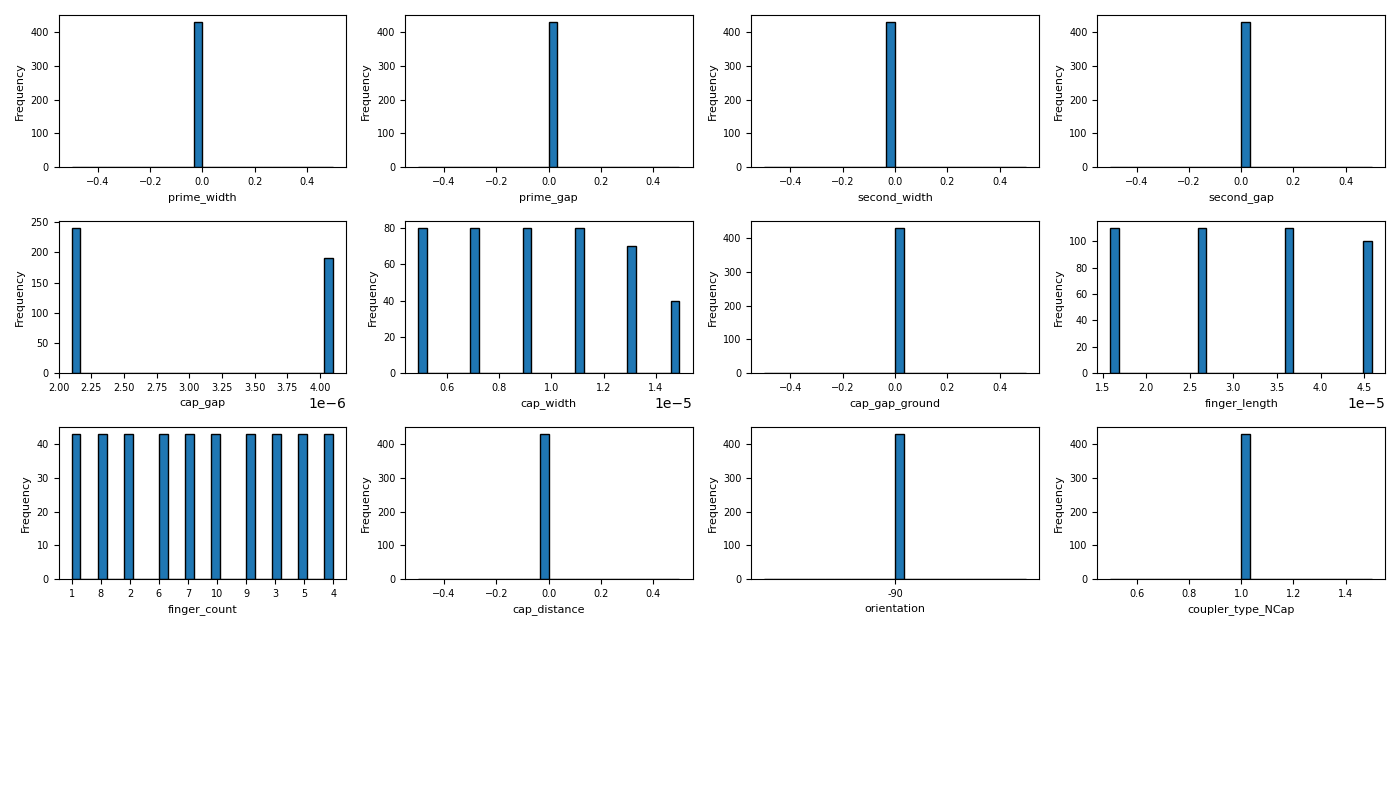

In [21]:
i=0
for y_encoding_format in y_encoding_formats:
    num_cols = len(y_encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_encoding_format[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

In [22]:
plt.close()

## Augment 

### Scale X

Scale kappa and frequency to be between 0 and 1

In [23]:
X_scaled = X.copy()
for col in X_scaled.columns:
    scaler = MinMaxScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]]) #only fit to this column
    joblib.dump(scaler, f'scalers/scaler_X_{col}.save') #save for later

In [24]:
# Check the scaling
display(X_scaled)

,top_to_top,top_to_bottom,top_to_ground,bottom_to_bottom,bottom_to_ground,ground_to_ground
0,0.018092,0.002850,0.074639,0.000626,0.000000,0.014872
1,0.637910,0.663783,0.568658,0.619091,0.586796,0.594135
2,0.056654,0.046526,0.098925,0.069578,0.085215,0.086718
3,0.349108,0.382292,0.283450,0.319701,0.275593,0.281949
4,0.361766,0.333311,0.414781,0.360265,0.376919,0.392763
...,...,...,...,...,...,...
425,0.073774,0.012263,0.210282,0.023780,0.031801,0.066631
426,0.086942,0.059401,0.159914,0.118393,0.158383,0.156307
427,0.386233,0.296003,0.549446,0.321032,0.337507,0.400786
428,0.048914,0.058525,0.054276,0.079001,0.093100,0.074982


### Scale y

In [25]:
y_scaled_encoding_formats = []

i=0
for y_encoding_format in y_encoding_formats:
    y_scaled = y_encoding_format.copy()
    for col in y_scaled.columns:
        scaler = MinMaxScaler()
        y_scaled[col] = scaler.fit_transform(y_scaled[[col]]) #only fit to this column
        joblib.dump(scaler, f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save') #save for later
    y_scaled_encoding_formats.append(y_scaled)
    i+=1

### Plot Scaled Data

### X

In [26]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X.columns):
    axes[i].hist(X[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/scaled_X_data.png')
plt.close()

### Y

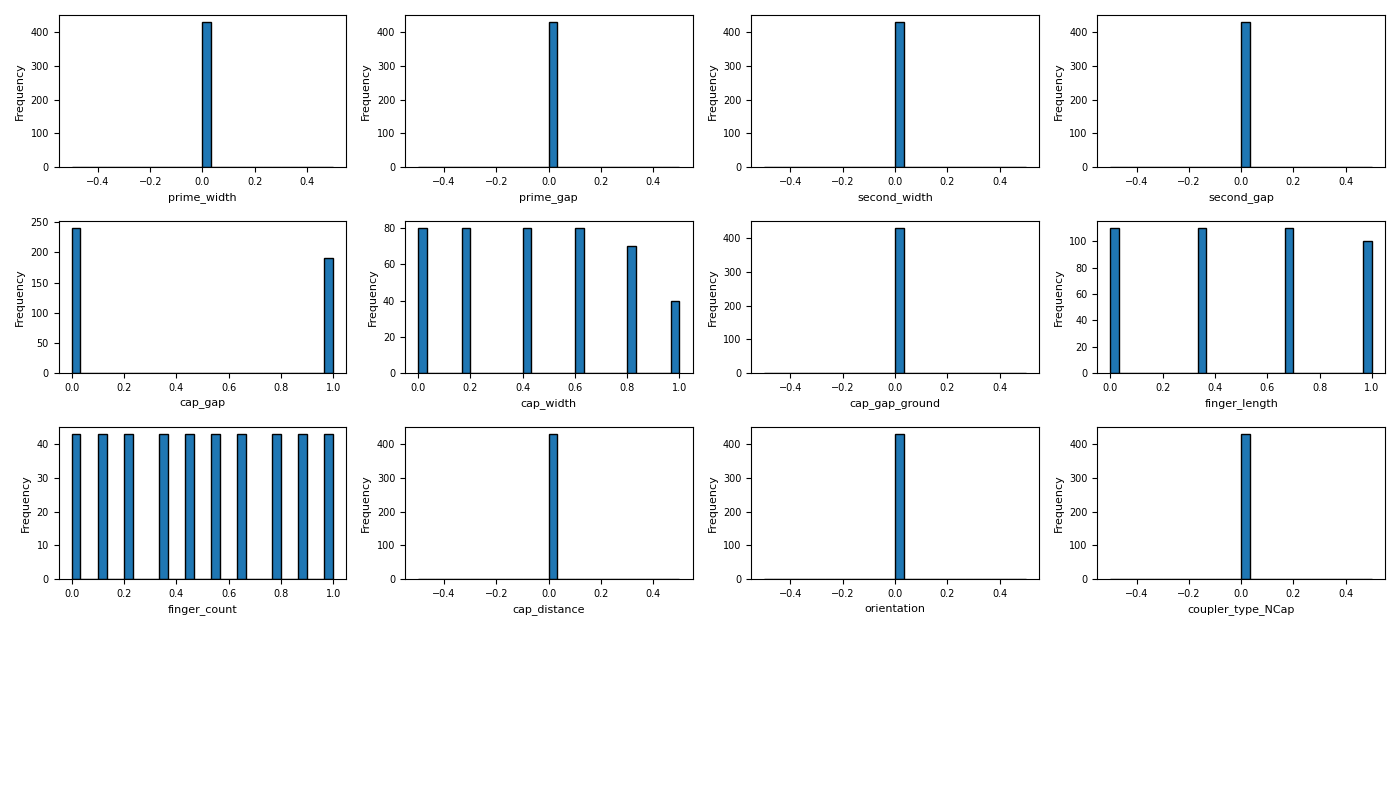

In [27]:
i=0
for y_scaled in y_scaled_encoding_formats:

    num_cols = len(y_scaled.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_scaled.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_scaled[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/scaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

In [28]:
plt.close()

### Unscale to make sure you can recreate original values with saved scaler

### 
Unscale X

In [29]:
X_orig = X_scaled.copy()
for col in X_scaled.columns:
    scaler = joblib.load(f'scalers/scaler_X_{col}.save')
    X_orig[col] = scaler.inverse_transform(X_scaled[[col]]) 

display(X_orig)

,top_to_top,top_to_bottom,top_to_ground,bottom_to_bottom,bottom_to_ground,ground_to_ground
0,15.65491,0.51663,14.95437,12.78614,12.09846,58.45017
1,65.85844,36.28408,29.22434,94.96956,58.07364,124.18885
2,18.77838,2.88026,15.65588,21.94864,18.77498,66.60369
3,42.46632,21.05076,20.98596,55.18578,33.69106,88.75992
4,43.49158,18.40010,24.77954,60.57606,41.62987,101.33585
...,...,...,...,...,...,...
425,20.16504,1.02606,18.87248,15.86284,14.59008,64.32406
426,21.23155,3.57699,17.41757,28.43531,24.50768,74.50121
427,45.47336,16.38109,28.66939,55.36257,38.54199,102.24635
428,18.15142,3.52960,14.36617,23.20076,19.39282,65.27181


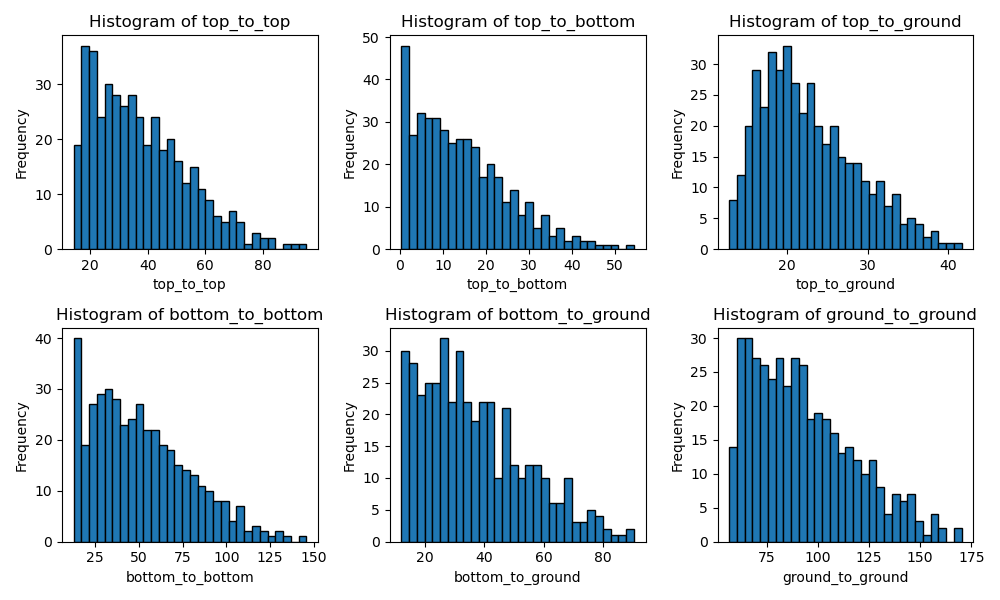

In [30]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X_orig.columns):
    axes[i].hist(X_orig[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

### Unscale Y

In [31]:
y_orig_encoding_formats = []

i=0
for y_scaled in y_scaled_encoding_formats:
    y_orig = y_scaled.copy()
    for col in y_scaled.columns:
        scaler = joblib.load(f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save')
        y_orig[col] = scaler.inverse_transform(y_scaled[[col]])
    y_orig_encoding_formats.append(y_orig)
    print('Encoding Type: ', y_encoding_format_names[i])
    display(y_orig)
    print('\n')
    i+=1

Encoding Type:  one_hot


,design_options.prime_width,design_options.prime_gap,design_options.second_width,design_options.second_gap,design_options.cap_gap,design_options.cap_width,design_options.cap_gap_ground,design_options.finger_length,design_options.finger_count,design_options.cap_distance,design_options.orientation,coupler_type_NCap
0,0.000012,0.000005,0.000012,0.000005,0.000002,0.000005,0.000005,0.000026,1.0,0.000051,-90.0,1.0
1,0.000012,0.000005,0.000012,0.000005,0.000002,0.000011,0.000005,0.000046,8.0,0.000051,-90.0,1.0
2,0.000012,0.000005,0.000012,0.000005,0.000004,0.000007,0.000005,0.000036,2.0,0.000051,-90.0,1.0
3,0.000012,0.000005,0.000012,0.000005,0.000002,0.000007,0.000005,0.000046,6.0,0.000051,-90.0,1.0
4,0.000012,0.000005,0.000012,0.000005,0.000004,0.000009,0.000005,0.000046,6.0,0.000051,-90.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
425,0.000012,0.000005,0.000012,0.000005,0.000002,0.000011,0.000005,0.000036,1.0,0.000051,-90.0,1.0
426,0.000012,0.000005,0.000012,0.000005,0.000004,0.000013,0.000005,0.000026,2.0,0.000051,-90.0,1.0
427,0.000012,0.000005,0.000012,0.000005,0.000004,0.000011,0.000005,0.000046,5.0,0.000051,-90.0,1.0
428,0.000012,0.000005,0.000012,0.000005,0.000004,0.000005,0.000005,0.000016,4.0,0.000051,-90.0,1.0


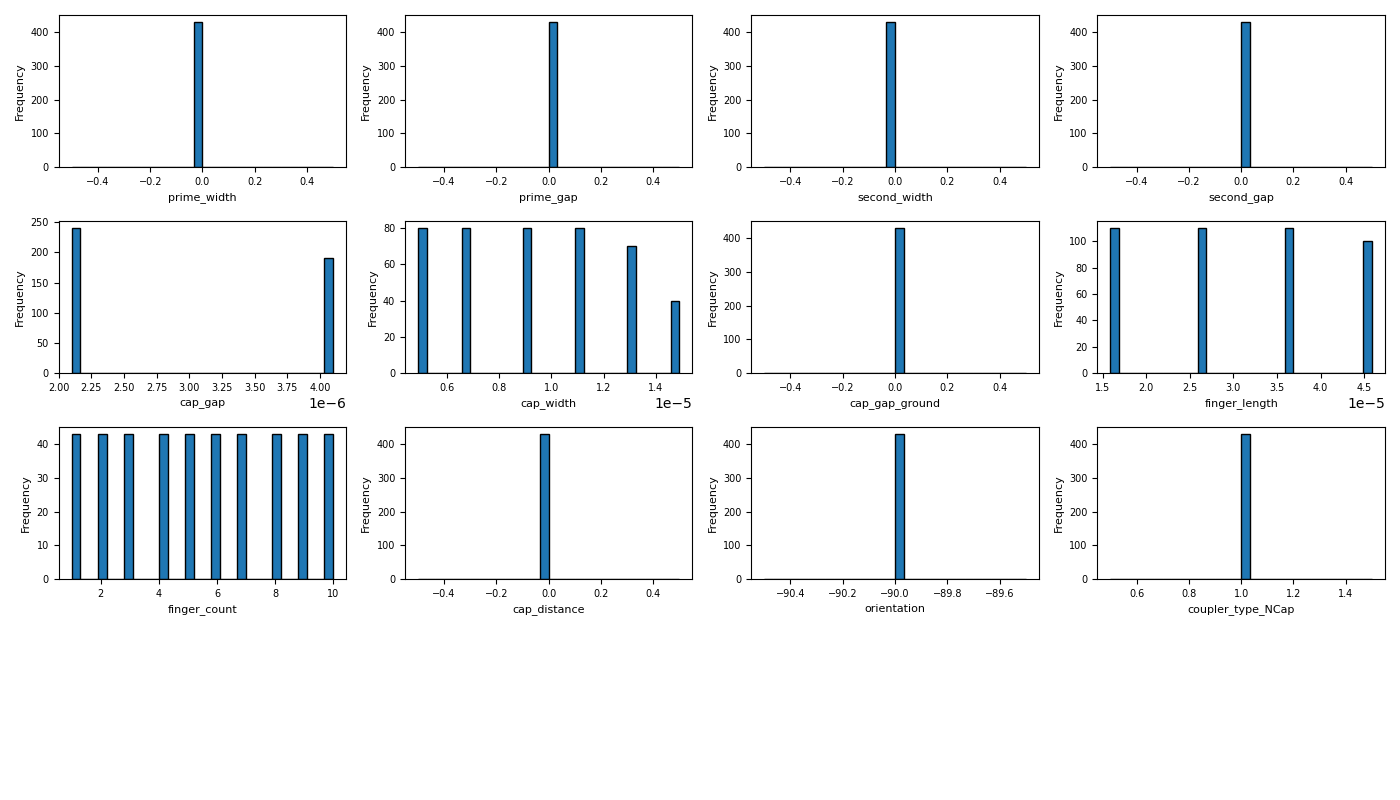

In [32]:
i=0
for y_orig in y_orig_encoding_formats:
    num_cols = len(y_orig.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for i, col in enumerate(y_orig.columns):
        try:
            plt.subplot(num_rows, 4, i + 1)
            plt.hist(y_orig[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.show()
    i+=1

## Split

In [33]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

2025-10-27 16:42:10.842054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-27 16:42:10.842173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-27 16:42:10.844129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-27 16:42:10.851445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow ver. 2.16.2


Dataset split is 80%-20% training-validation and test sets. We use a constant state (seed) for reproducible splits across multiple runs.

In [34]:
# Unscaled data split
if 'one hot' in ENCODING_TYPE:
    X_train, X_val_test, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val, X_test, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train, X_val_test, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val, X_test, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )
elif 'Try Both' in ENCODING_TYPE:
    X_train_one_hot_encoding, X_val_test_one_hot_encoding, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_one_hot_encoding, X_test_one_hot_encoding, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test_one_hot_encoding, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    )
    X_train_linear_encoding, X_val_test_linear_encoding, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_linear_encoding, X_test_linear_encoding, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test_linear_encoding, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )

# Scaled data split
if 'one hot' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_linear_hot_encoding, y_val_test_linear_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test
elif 'Try Both' in ENCODING_TYPE:
    X_train_scaled_one_hot_encoding, X_val_test_scaled_one_hot_encoding, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_one_hot_encoding, X_test_scaled_one_hot_encoding, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

    X_train_scaled_linear_encoding, X_val_test_scaled_linear_encoding, y_train_scaled_linear_encoding, y_val_test_scaled_linear_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_linear_encoding, X_test_scaled_linear_encoding, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled_linear_encoding, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test


In [35]:
#unscaled
if 'one hot' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (301, 12), 70.00%
Validation one-hot encoding set shape: (64, 12), 14.88%
Test set shape:                 (65, 12), 15.12%
---------------------------------------


In [36]:
#scaled
if 'one hot' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (301, 12), 70.00%
Validation one-hot encoding set shape: (64, 12), 14.88%
Test set shape:                 (65, 12), 15.12%
---------------------------------------


In [37]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train_scaled) #can check this in next script as well after loading to make sure it matches
    display(X_val_scaled)
else:
    display(X_train_scaled_one_hot_encoding) 
    display(X_val_scaled_one_hot_encoding)
    
    display(X_train_scaled_linear_encoding) 
    display(X_val_scaled_linear_encoding)

,top_to_top,top_to_bottom,top_to_ground,bottom_to_bottom,bottom_to_ground,ground_to_ground
402,0.251274,0.209921,0.335395,0.300816,0.362366,0.363198
118,0.403380,0.335865,0.525359,0.448767,0.525263,0.532313
114,0.095618,0.012225,0.269897,0.023431,0.031902,0.092625
137,0.906249,0.927437,0.818009,0.892457,0.867878,0.869796
318,0.031399,0.032418,0.054650,0.064245,0.085949,0.078035
...,...,...,...,...,...,...
71,0.069801,0.063492,0.104736,0.108498,0.139264,0.129734
106,0.134532,0.156900,0.109223,0.131186,0.113281,0.104658
270,0.464453,0.372188,0.621577,0.553515,0.675052,0.663103
348,0.197660,0.195139,0.215397,0.195356,0.193898,0.197688


,top_to_top,top_to_bottom,top_to_ground,bottom_to_bottom,bottom_to_ground,ground_to_ground
152,0.353064,0.303838,0.440994,0.385637,0.438642,0.444398
73,0.790189,0.780770,0.770817,0.795186,0.804299,0.811902
22,0.048970,0.019978,0.128327,0.043696,0.060115,0.071370
16,0.450407,0.377049,0.578701,0.420071,0.450143,0.493731
18,0.264472,0.221595,0.348543,0.274416,0.309140,0.324349
...,...,...,...,...,...,...
131,0.368525,0.269738,0.548237,0.345891,0.397539,0.445812
39,0.315511,0.241417,0.457468,0.384930,0.480745,0.475318
168,0.307234,0.292281,0.335096,0.294010,0.294018,0.309374
410,0.722965,0.666979,0.793767,0.727917,0.767276,0.782446


### Save

Save the split data set for future reference

In [38]:
!rm -f $DATA_DIR/npy/*npy

In [39]:
#unscaled
if 'one hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test)
    
    np.save('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), y_test_one_hot_encoding)
elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test)
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), y_test_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [40]:
#scaled
if 'one hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)

elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding) 
    np.save('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)

elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [41]:
!ls $DATA_DIR/npy/*npy

data/npy/x_test_one_hot_encoding_augmented.npy
data/npy/x_test_one_hot_encoding.npy
data/npy/x_train_one_hot_encoding_augmented.npy
data/npy/x_train_one_hot_encoding.npy
data/npy/x_val_one_hot_encoding_augmented.npy
data/npy/x_val_one_hot_encoding.npy
data/npy/y_test_one_hot_encoding_augmented.npy
data/npy/y_test_one_hot_encoding.npy
data/npy/y_train_one_hot_encoding_augmented.npy
data/npy/y_train_one_hot_encoding.npy
data/npy/y_val_one_hot_encoding_augmented.npy
data/npy/y_val_one_hot_encoding.npy


In [42]:
with open('X_names', 'w') as f:
        f.write('\n'.join(X.columns))